# Описание проекта

Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Теперь расскажем подробнее о задачах.

Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# Загрузка данных

Загрузка и подключение нужных библиотек

In [376]:
!pip install phik -q
!pip install scikit-learn==1.5.0 -q

In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.cluster import KMeans
import seaborn as sns
import phik
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [378]:
RANDOM_STATE=42

Загрузка датафреймов

In [379]:
try:
    test_features=pd.read_csv('/datasets/test_features.csv')
except FileNotFoundError:
    test_features=pd.read_csv('./test_features.csv')

In [380]:
try:   
    test_target_job_satisfaction_rate=pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except FileNotFoundError:
    test_target_job_satisfaction_rate=pd.read_csv('./test_target_job_satisfaction_rate.csv')

In [381]:
try:
    test_target_quit=pd.read_csv('/datasets/test_target_quit.csv')
except FileNotFoundError:
    test_target_quit=pd.read_csv('./test_target_quit.csv') 

In [382]:
try:
    train_job_satisfaction_rate=pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except FileNotFoundError:    
    train_job_satisfaction_rate=pd.read_csv('./train_job_satisfaction_rate.csv')

In [383]:
try:
    train_quit=pd.read_csv('/datasets/train_quit.csv')
except FileNotFoundError:    
    train_quit=pd.read_csv('./train_quit.csv')

<b>Вывод:</b> 
- Были загружены и подключены нужные для работы библиотеки 
- Были загружены все датафреймы

# Предобработка данных

## test_features

Информазия о датафрейме

In [384]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Просмотр первых строк

In [385]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Количество пропусков в данных

In [386]:
test_features.isnull().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Вывод строк с пропусками по столбцу 'dept'

In [387]:
test_features[test_features['dept'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


Вывод строк с пропусками по столбцу 'level'

In [388]:
test_features[test_features['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


Поиск явных дубликатов

In [389]:
test_features.duplicated().sum()

0

Поиск неявных дубликатов плюс создание списка с категориальными признаками для дальнейшего анализа

In [390]:
test_features_categor=[]
for column in test_features.select_dtypes(include=['object']):
    print(column, test_features[column].unique())
    test_features_categor.append(column)

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Обнаружены аномальные значение в столбцах 'workload' и 'dept' . Выведем их

In [391]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [392]:
test_features[test_features['dept']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


Замена всех пробелов на nan

In [393]:
test_features=test_features.replace(r'^\s*$', np.nan, regex=True)

Проверка результатов

In [394]:
test_features[test_features['dept']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [395]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [396]:
test_features.isnull().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

## test_target_job_satisfaction_rate

Информация о датафрейме

In [397]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Просмотр первых строк 

In [398]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Поиск пропусков

In [399]:
test_target_job_satisfaction_rate.isnull().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

Поиск дубликатов

In [400]:
test_target_job_satisfaction_rate.duplicated().sum()

0

## test_target_quit

Информация о датафрейме

In [401]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Просмотр первых строк 

In [402]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Поиск пропусков

In [403]:
test_target_quit.isnull().sum()

id      0
quit    0
dtype: int64

Поиск дубликатов

In [404]:
test_target_quit.duplicated().sum()

0

Проверка на случай неявных дубликатов

In [405]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

## train_job_satisfaction_rate

Информация о датафрейме

In [406]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Просмотр первых строк

In [407]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Поиск пропусков

In [408]:
train_job_satisfaction_rate.isnull().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Вывод строк с пропусками по столбикам 'dept' и 'level'

In [409]:
train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [410]:
train_job_satisfaction_rate[train_job_satisfaction_rate['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Поиск дубликатов

In [411]:
train_job_satisfaction_rate.duplicated().sum()

0

Поиск неявных дубликатов плюс создание списка категориальных признаков для дальнейшего анализа

In [412]:
train_job_satisfaction_rate_categor=[]
for column in train_job_satisfaction_rate.select_dtypes(include=['object']):
    print(column, train_job_satisfaction_rate[column].unique())
    train_job_satisfaction_rate_categor.append(column)

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


## train_quit

Просмотр информации о датафрейме

In [413]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Вывод первых строк

In [414]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Поиск пропусков

In [415]:
train_quit.isnull().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Поиск дубликатов

In [416]:
train_quit.duplicated().sum()

0

Поиск неявных дубликатов плюс создание списка с категориальными признаками для дальнейшего анализа

In [417]:
train_quit_categor=[]
for column in train_quit.select_dtypes(include=['object']):
    print(column, train_quit[column].unique())
    train_quit_categor.append(column)

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


Подготовка пайплайна для заполнения пропусков

In [418]:
one_pipe = Pipeline(
    [
        (
            'simpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Использование пайплайнов для заполнения пропусков

In [419]:
test_features[['dept', 'level', 'workload']] = one_pipe.fit_transform(test_features[['dept', 'level', 'workload']])
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [420]:
train_job_satisfaction_rate[['dept', 'level']]=one_pipe.fit_transform(train_job_satisfaction_rate[['dept', 'level']])
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


<b>Вывод:</b>

1) test_features
  - В данных были обнаружены пропуски в столбцах 'dept' и 'level'
  - Были обнаружены пустые значения в столбцах 'workload' и 'dept'
  - Остально все нормально, неявных пропусков не обнаружено, названия столбцов в змеином регистре, типы данных присвоены правильно
    
2) test_target_job_satisfaction_rate
  - Проблем не обнаружено
    
3) test_target_quit
  - Проблем не обнаружено
    
4) train_job_satisfaction_rate
  - В данных были обнаружены пропуски в столбцах 'dept' и 'level'
    
5) train_quit
  - Проблем не обнаружено
    
6) Везде был замечен нюанс sinior очень странно написан, но я решил не трогать вдруг так и надо

# Исследовательский анализ данных

Далее будем использовать только 
- train_job_satisfaction_rate
- test_features
- test_target_job_satisfaction_rate

## train_job_satisfaction_rate

In [421]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Отбор численных признаков

In [422]:
train_job_satisfaction_rate_num=[]
for column in train_job_satisfaction_rate.select_dtypes(include=['int', 'float']):
    train_job_satisfaction_rate_num.append(column)
train_job_satisfaction_rate_num.remove('id')
train_job_satisfaction_rate_num

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

### Функция для построения гистограммы

In [492]:
def hist_plot(df, iput_data):
    for column in iput_data:
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        plt.hist(df[column], bins=30, edgecolor='black')
        plt.xlabel(f'Значения столбца "{column}"')
        plt.ylabel('Частота')
        plt.title(f'Гистограмма для "{column}"');              

Построим гистограмму для train_job_satisfaction_rate по численным признакам

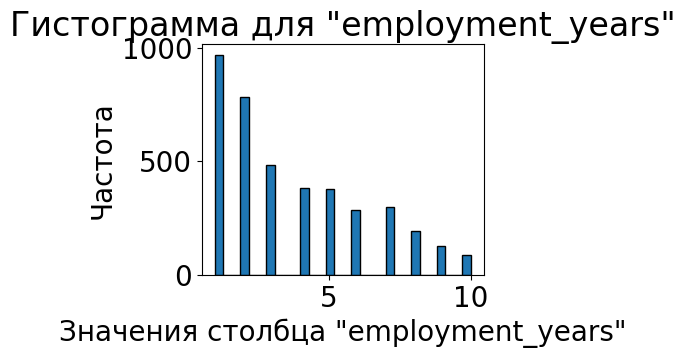

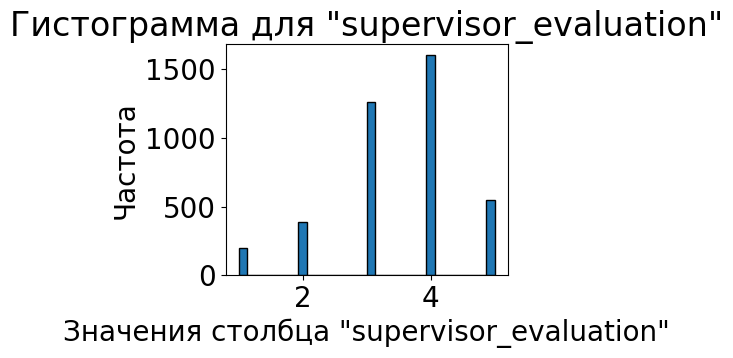

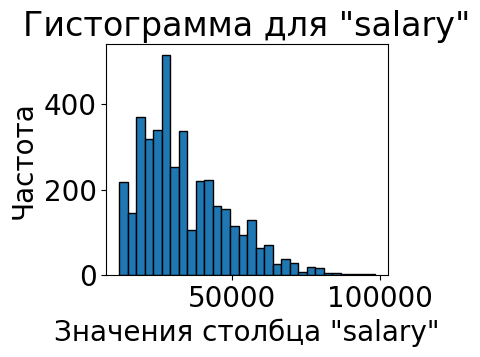

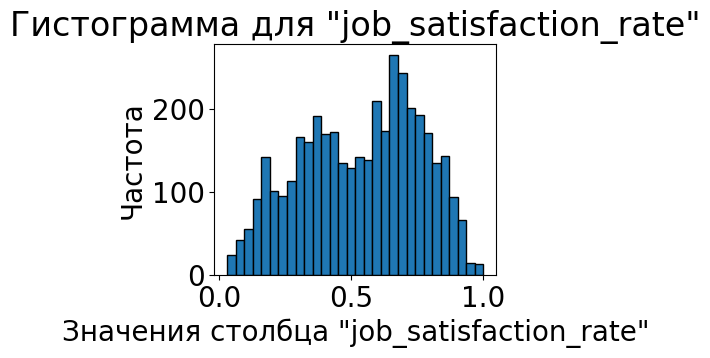

In [493]:
hist_plot(train_job_satisfaction_rate, train_job_satisfaction_rate_num)

### Функция для построения графика боксплота

In [425]:
def boxplot_plot(df, iput_data):
    for column in iput_data:
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        plt.boxplot(df[column])
        plt.xlabel(f'Столбец "{column}"')
        plt.ylabel('Значения')
        plt.title(f'Ящик с усами для "{column}"');

Построим график боксплота для train_job_satisfaction_rate по численным признакам

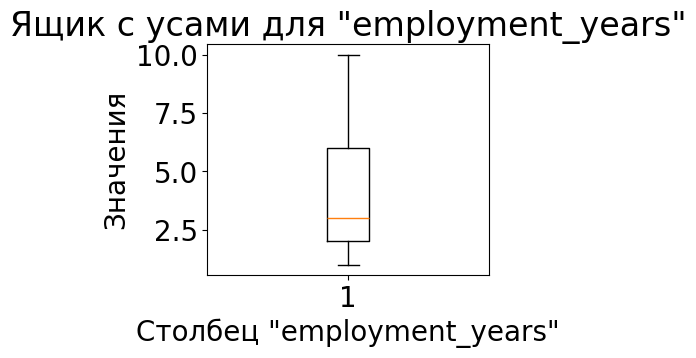

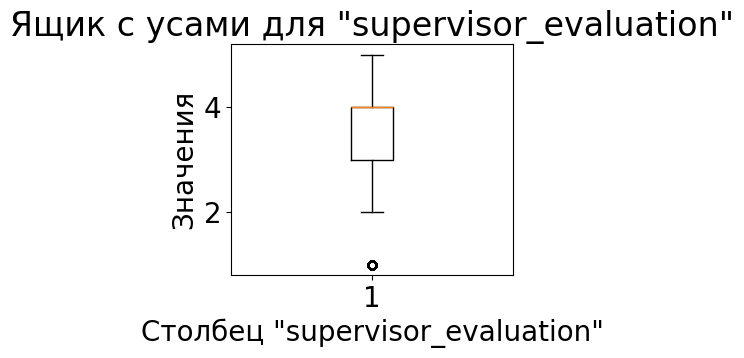

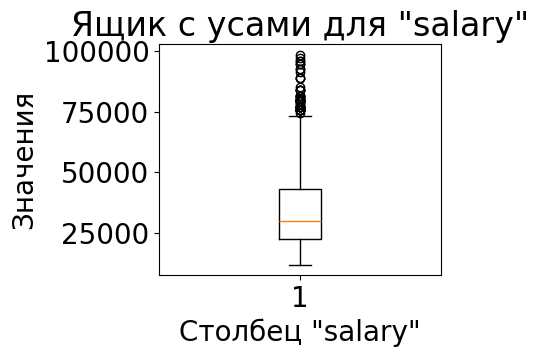

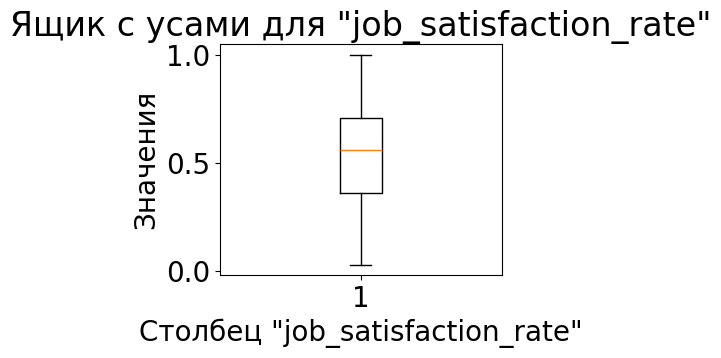

In [426]:
boxplot_plot(train_job_satisfaction_rate, train_job_satisfaction_rate_num)

### Функция для построения графика круговой диаграммы

In [427]:
def pie_plot(df, input_data):
    for column in input_data:
        counts = df[column].value_counts()
        explode = [0.05] + [0] * (len(counts) - 1)
        plt.figure(figsize=(8, 8))
        plt.pie(counts, explode=explode, labels=counts.index,  autopct='%1.1f%%',  startangle=140)
        plt.title(f'Круговая диаграмма "{column}"')

Построим график круговую диаграмму для train_job_satisfaction_rate по категориальным признакам

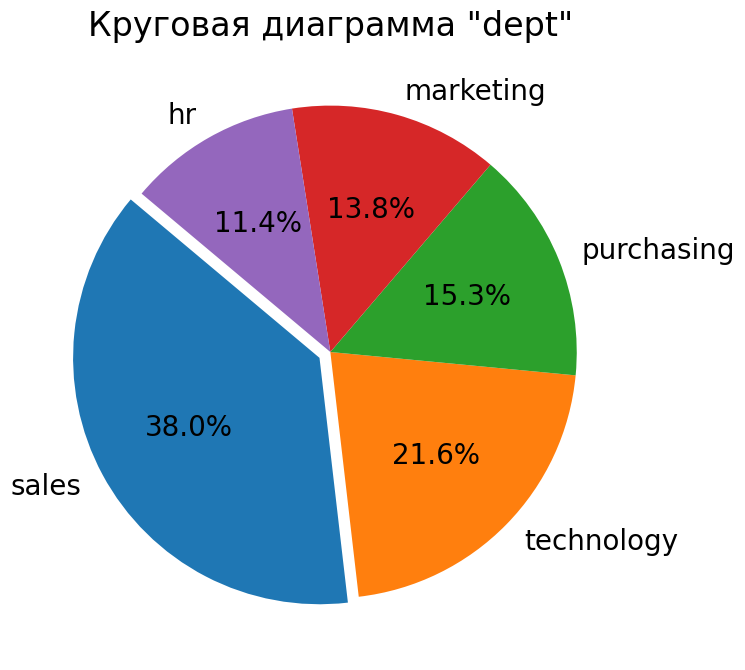

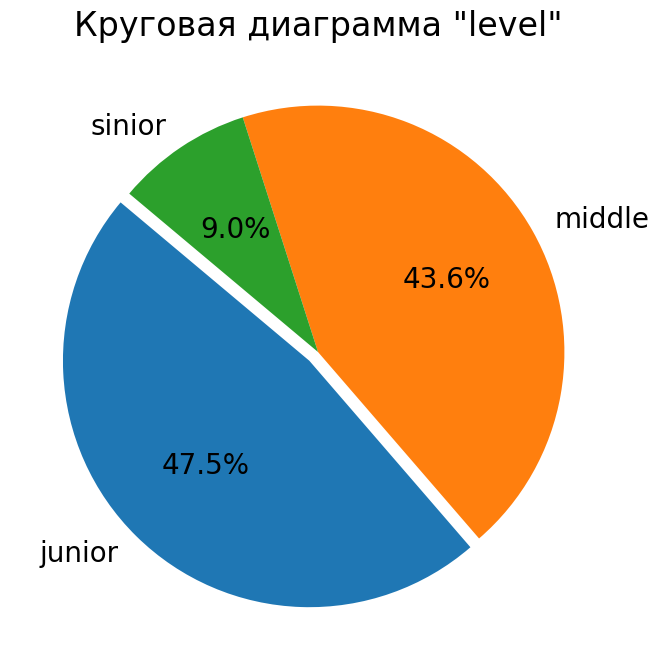

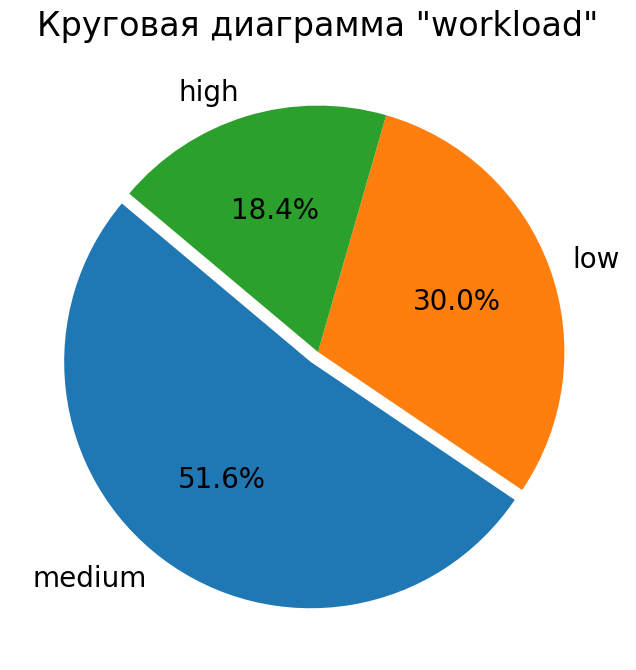

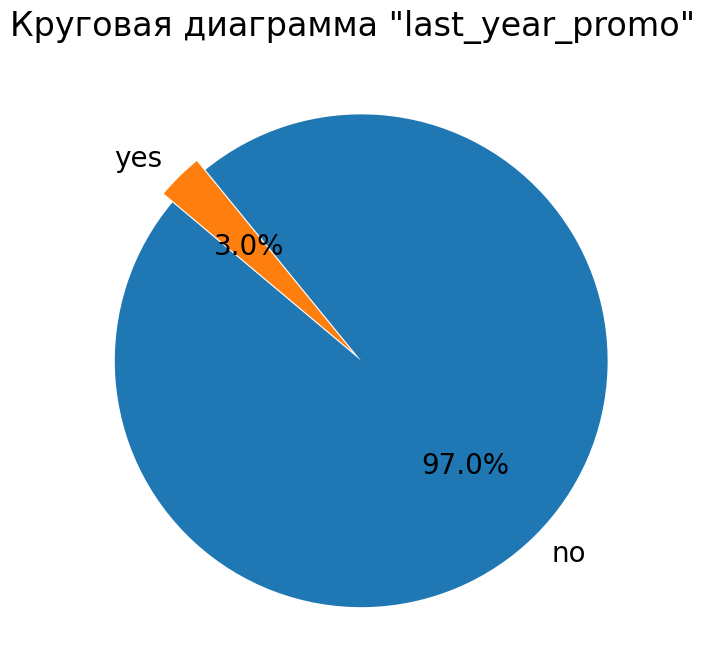

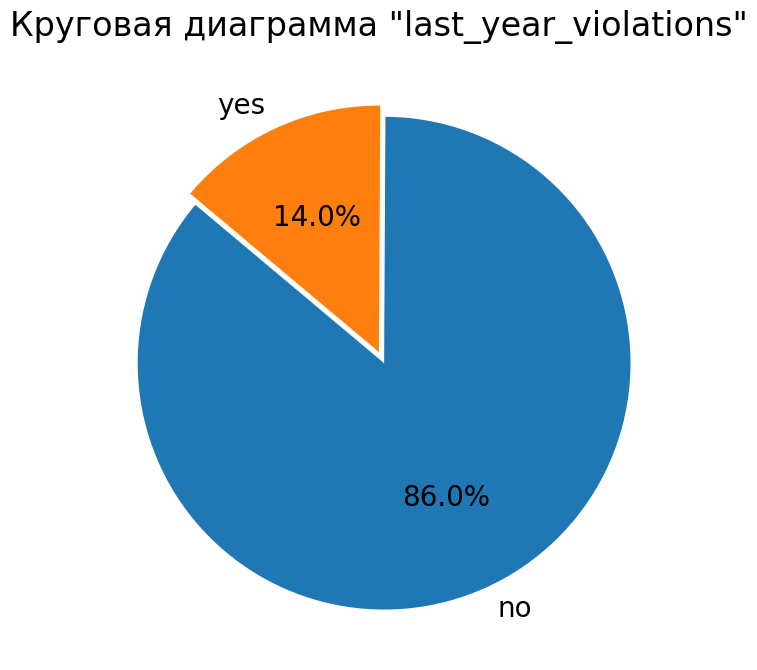

In [428]:
pie_plot(train_job_satisfaction_rate, train_job_satisfaction_rate_categor)

### Функция описательной статистики

In [429]:
def describe_plot(df, input_data):
    print(df[input_data].describe())

Выведем описательную статистику для train_job_satisfaction_rate

In [430]:
describe_plot(train_job_satisfaction_rate, train_job_satisfaction_rate_num)

       employment_years  supervisor_evaluation        salary  \
count       4000.000000            4000.000000   4000.000000   
mean           3.718500               3.476500  33926.700000   
std            2.542513               1.008812  14900.703838   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  22800.000000   
50%            3.000000               4.000000  30000.000000   
75%            6.000000               4.000000  43200.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000  


In [431]:
describe_plot(train_job_satisfaction_rate, train_job_satisfaction_rate_categor)

         dept   level workload last_year_promo last_year_violations
count    4000    4000     4000            4000                 4000
unique      5       3        3               2                    2
top     sales  junior   medium              no                   no
freq     1518    1898     2066            3880                 3441


### Функция для построения матрицы корреляции

In [432]:
def phik_matrix_plot(df, input_data):
    phik_matrix=df[input_data].phik_matrix(interval_cols=input_data)
    print(phik_matrix)
    plt.figure(figsize=(10,7))
    sns.heatmap(phik_matrix, annot=True);

Построим матрицу корреляции для train_job_satisfaction_rate по численным признакам

                       employment_years  supervisor_evaluation    salary  \
employment_years               1.000000               0.000000  0.483419   
supervisor_evaluation          0.000000               1.000000  0.000000   
salary                         0.483419               0.000000  1.000000   
job_satisfaction_rate          0.325603               0.764364  0.165830   

                       job_satisfaction_rate  
employment_years                    0.325603  
supervisor_evaluation               0.764364  
salary                              0.165830  
job_satisfaction_rate               1.000000  


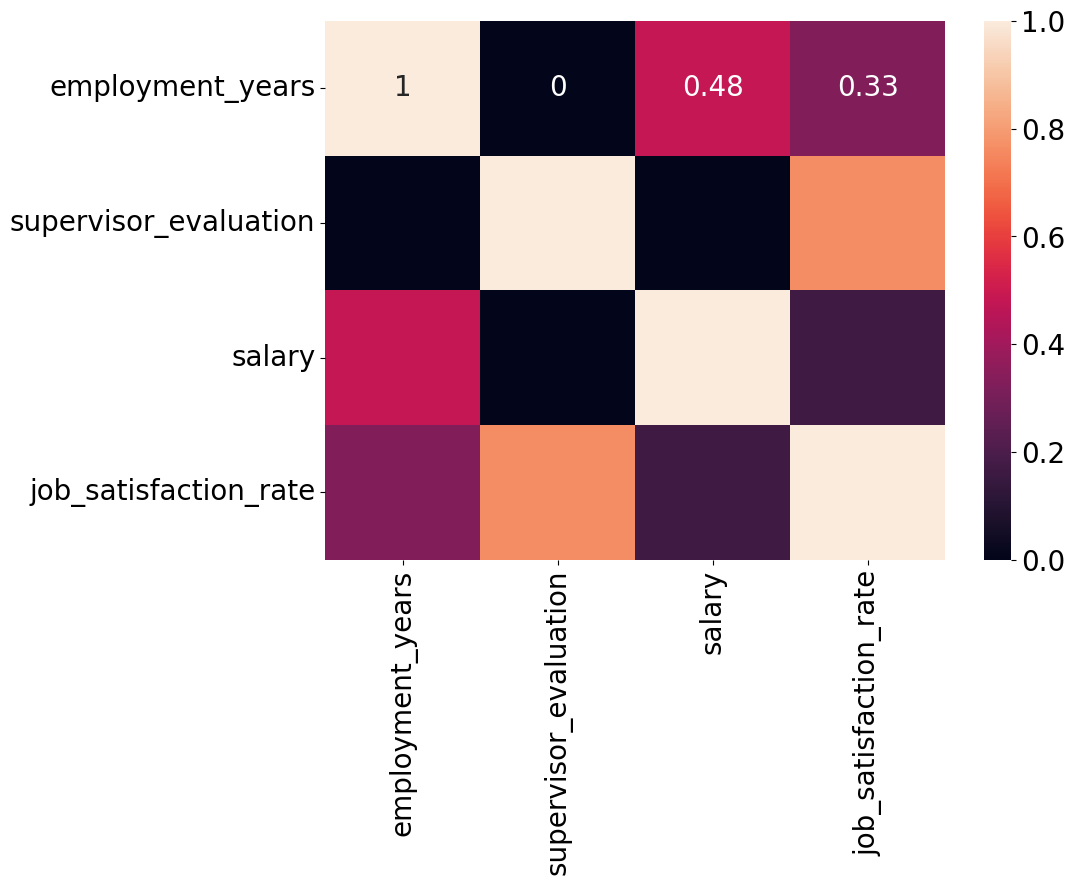

In [433]:
phik_matrix_plot(train_job_satisfaction_rate, train_job_satisfaction_rate_num)

## test_features

In [434]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Отбор численных признаков

In [435]:
test_features_num=[]
for column in test_features.select_dtypes(include=['int', 'float']):
    test_features_num.append(column)
test_features_num.remove('id')
test_features_num

['employment_years', 'supervisor_evaluation', 'salary']

Гистограмма по численным признакам 

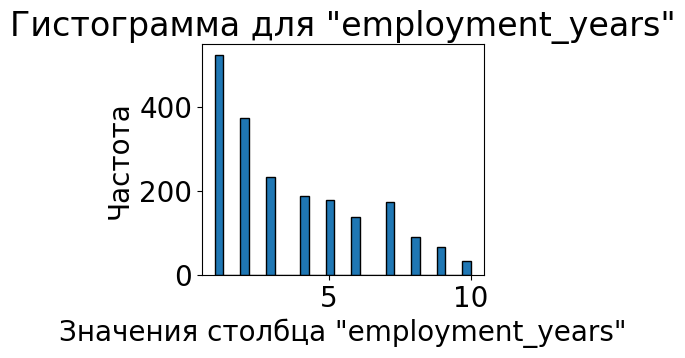

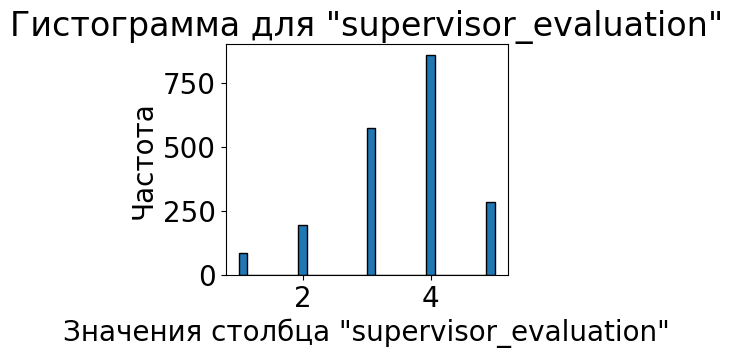

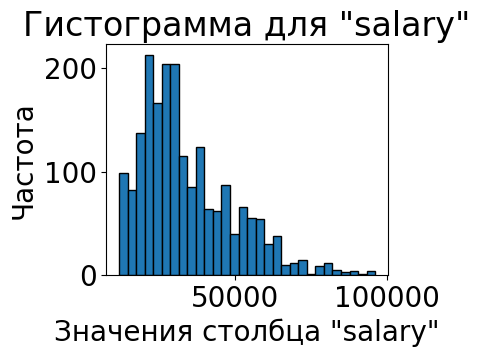

In [436]:
hist_plot(test_features,test_features_num)

График боксплота для численных методов

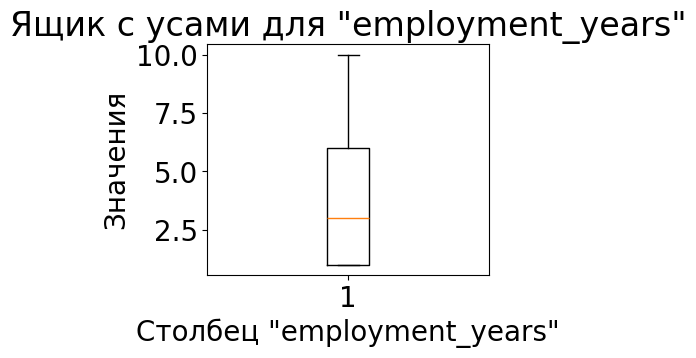

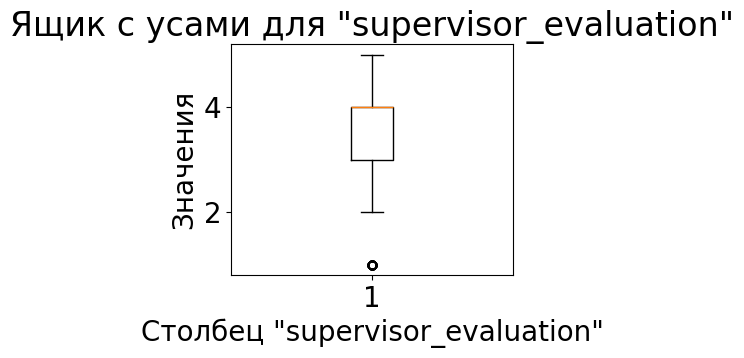

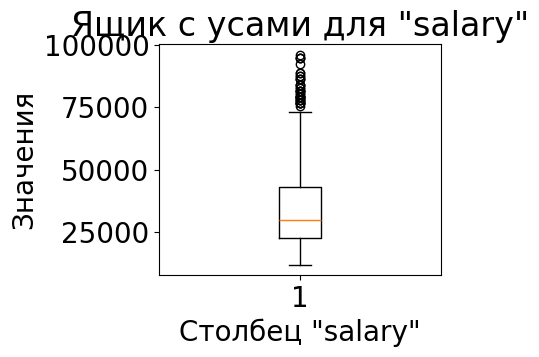

In [437]:
boxplot_plot(test_features,test_features_num)

Вывод круговой диаграммы по категориальным признакам

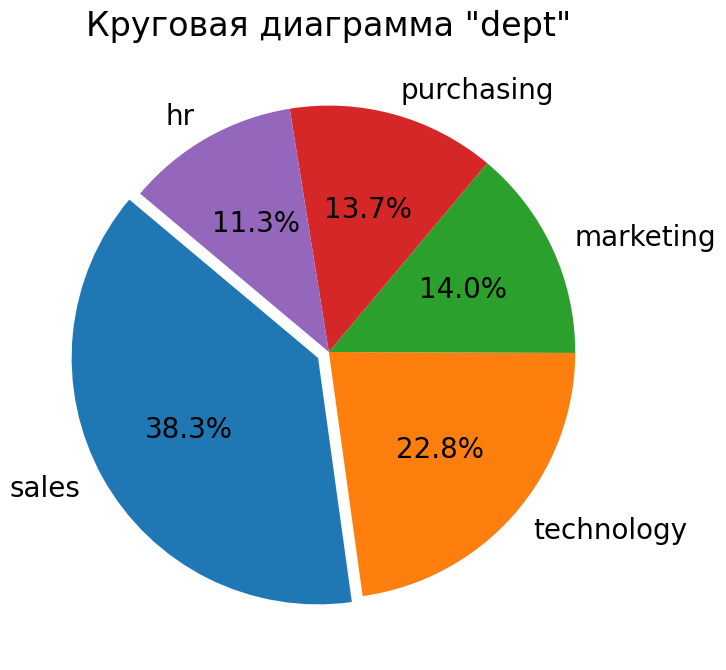

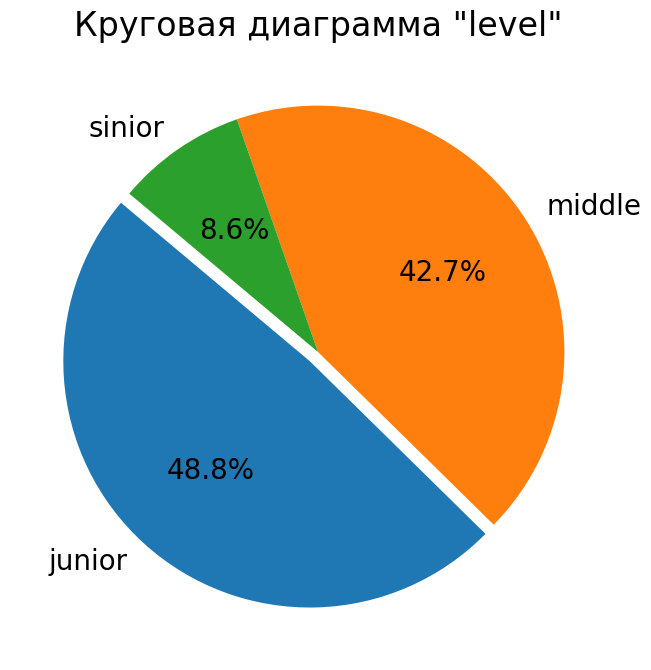

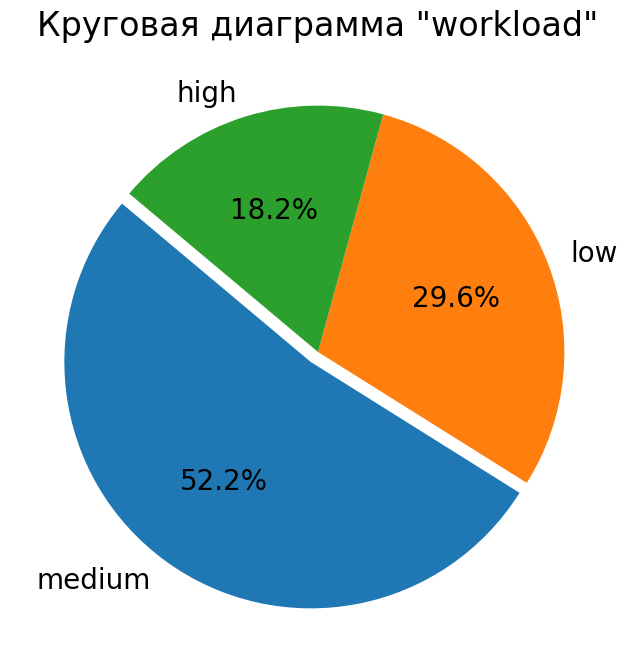

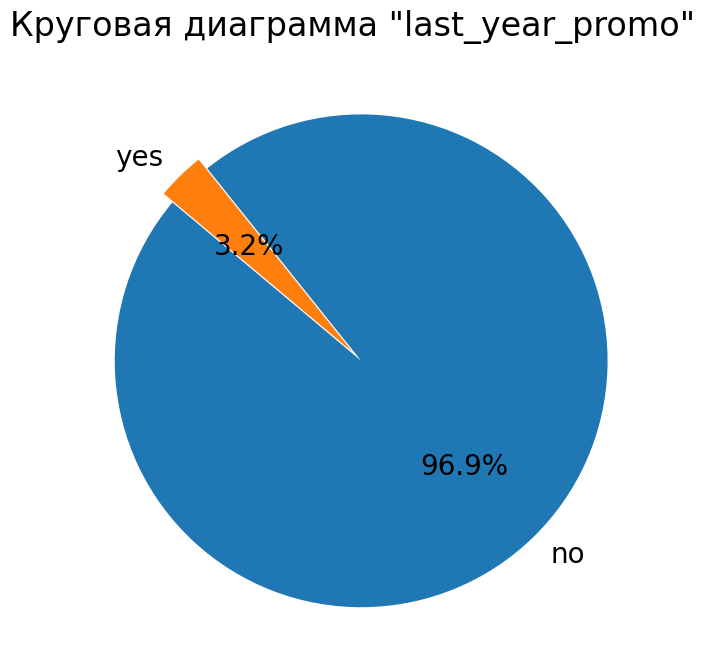

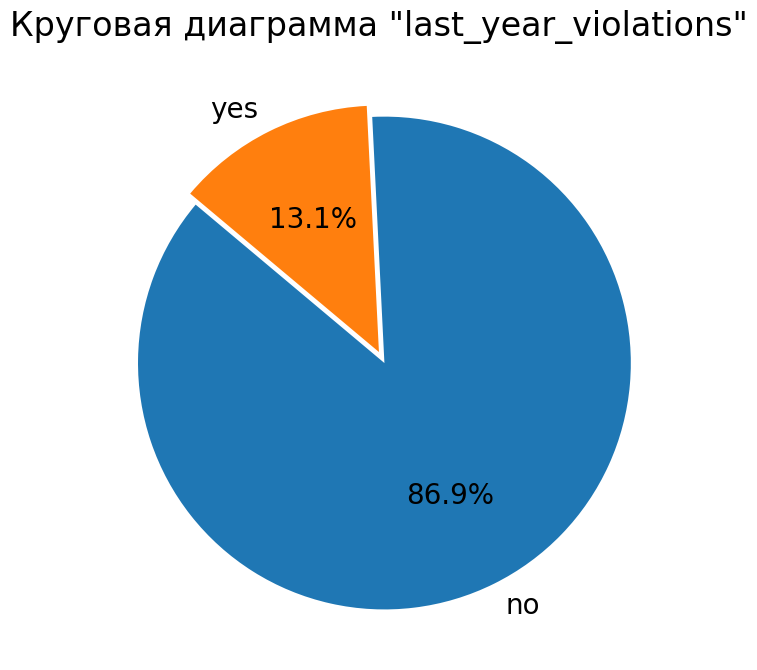

In [438]:
pie_plot(test_features,test_features_categor)

Описательная статистика

In [439]:
describe_plot(test_features,test_features_num)

       employment_years  supervisor_evaluation        salary
count       2000.000000            2000.000000   2000.000000
mean           3.666500               3.526500  34066.800000
std            2.537222               0.996892  15398.436729
min            1.000000               1.000000  12000.000000
25%            1.000000               3.000000  22800.000000
50%            3.000000               4.000000  30000.000000
75%            6.000000               4.000000  43200.000000
max           10.000000               5.000000  96000.000000


In [440]:
describe_plot(test_features,test_features_categor)

         dept   level workload last_year_promo last_year_violations
count    2000    2000     2000            2000                 2000
unique      5       3        3               2                    2
top     sales  junior   medium              no                   no
freq      766     975     1044            1937                 1738


Матрица корреляции

                       employment_years  supervisor_evaluation    salary
employment_years               1.000000               0.000000  0.494701
supervisor_evaluation          0.000000               1.000000  0.114588
salary                         0.494701               0.114588  1.000000


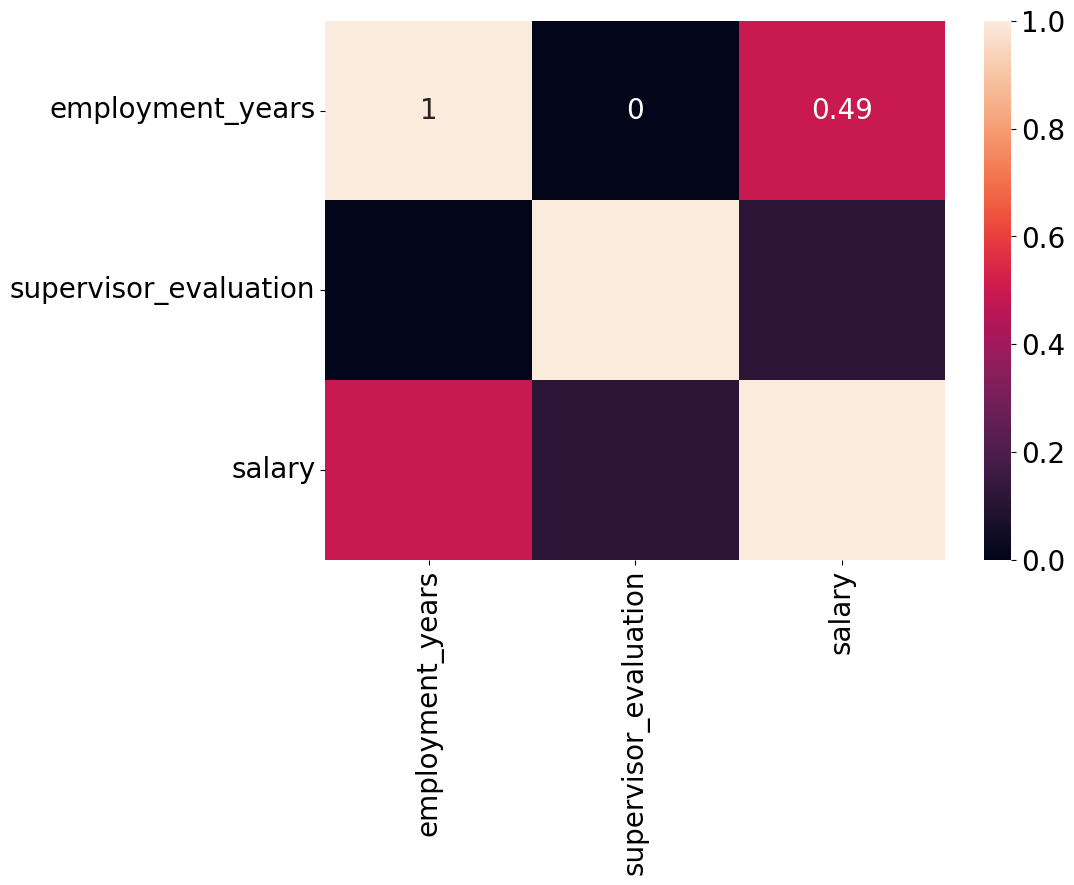

In [441]:
phik_matrix_plot(test_features,test_features_num)

## test_target_job_satisfaction_rate

In [442]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Присвоение численного признака

In [443]:
test_target_job_satisfaction_rate_num=['job_satisfaction_rate']

In [444]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [445]:
test_target_job_satisfaction_rate['id'].unique().size

2000

Построение гистограммы

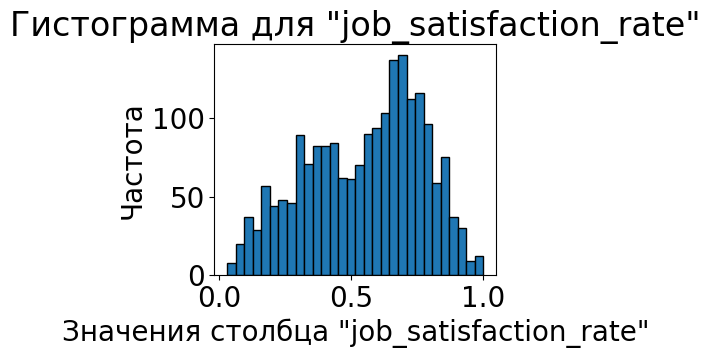

In [449]:
hist_plot(test_target_job_satisfaction_rate, test_target_job_satisfaction_rate_num)

Построение графика боксплота

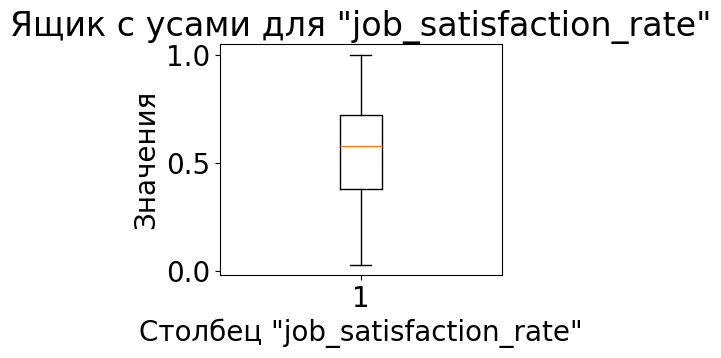

In [450]:
boxplot_plot(test_target_job_satisfaction_rate, test_target_job_satisfaction_rate_num)

# Подготовка данных

Для эффективной обработки данных, следует применить различные методы кодирования и нормализации к разным типам признаков:

1. Категориальные признаки с использованием OneHotEncoder:

- dept: Категория отдела.

- last_year_promo: Индикатор прошлогоднего повышения.

- last_year_violations: Уровень нарушений за прошлый год.

Для этих признаков рекомендуется использовать OneHotEncoder, который преобразует категории в набор бинарных признаков.

2. Порядковые признаки с использованием OrdinalEncoder:

- level: Уровень должности.

- workload: Уровень нагрузки.

Примените OrdinalEncoder для этих признаков, чтобы сохранить их порядковую природу, преобразуя категории в числовые значения.

3. Количественные признаки с использованием StandardScaler:

- employment_years: Количество лет в компании.

- supervisor_evaluation: Оценка руководителя.

- salary: Размер зарплаты.

Для стандартизации этих количественных признаков используйте StandardScaler, который приведет их к единому масштабу, улучшая производительность моделей машинного обучения.

Обьединение таблиц чтобы добавить входной признак

In [451]:
all_target = test_target_job_satisfaction_rate.merge(test_features, on='id', how='left')
display(all_target.head())

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,130604,0.74,technology,junior,medium,1,no,no,4,34800
1,825977,0.75,marketing,middle,high,7,no,no,5,58800
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200
3,555320,0.72,technology,junior,medium,1,no,no,4,34800
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000


Подготовка данных для модели машинного обучения

In [452]:
X_train=train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train=train_job_satisfaction_rate['job_satisfaction_rate']
X_test=all_target.drop(['job_satisfaction_rate','id'], axis=1)
y_test=all_target['job_satisfaction_rate']

Подготовка колонок для предобработки данных 

In [453]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Создание пайплайнов для предобработки данных

In [454]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [455]:
ord_pipe=Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
) 

In [456]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [457]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [458]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

# Обучение моделей

Расчет метрики "Процент относительной ошибки"

In [459]:
def metric(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
   
smape_scorer = make_scorer(score_func=metric, greater_is_better=False)

Найдем наилучшие параметры для модели

In [460]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)
grid_search.fit(X_train, y_train)

D:\PyCharm\Anaconda\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['junior',
                                                                                                                      'middle',
                                                                                                                      's...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(metric, greater_is_better=False, response_method='predict'))

Вывод наилучшей модели 

In [461]:
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)
round(grid_search.best_score_*(-1),2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                              

15.01

In [462]:
best_model = grid_search.best_estimator_
best_model
round(grid_search.best_score_*(-1),2)

15.01

In [463]:
round(smape(y_test, best_model.predict(X_test)),2)

14.28

# Оформление вывода

Для определения оптимальной модели был проведен комплексный анализ:

    1) Был выполнен анализ входных данных и их характеристик для лучшего понимания и подготовки к моделированию.
    2) В рамках исследования были использованы две различные модели классификации, что позволило сравнить их эффективность и выбрать наиболее подходящую.
    3) На основе метрики SMAPE (Symmetric Mean Absolute Percentage Error) была выбрана оптимальная модель. В данном случае, лучшей оказалась модель DecisionTreeRegressor
    4) Метрика SMAPE для этой лучшей модели на тренировочной выборке составила 14.28, что указывает на её высокую точность и пригодность для дальнейшего использования.

# Исследовательский анализ данных

Далее будем использовать только 
- train_quit
- test_features
- test_target_quit

In [464]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Построим круговую диаграмму 'Соотношение средней зарплаты ушедших сотрудников с теми, кто остался в компании'

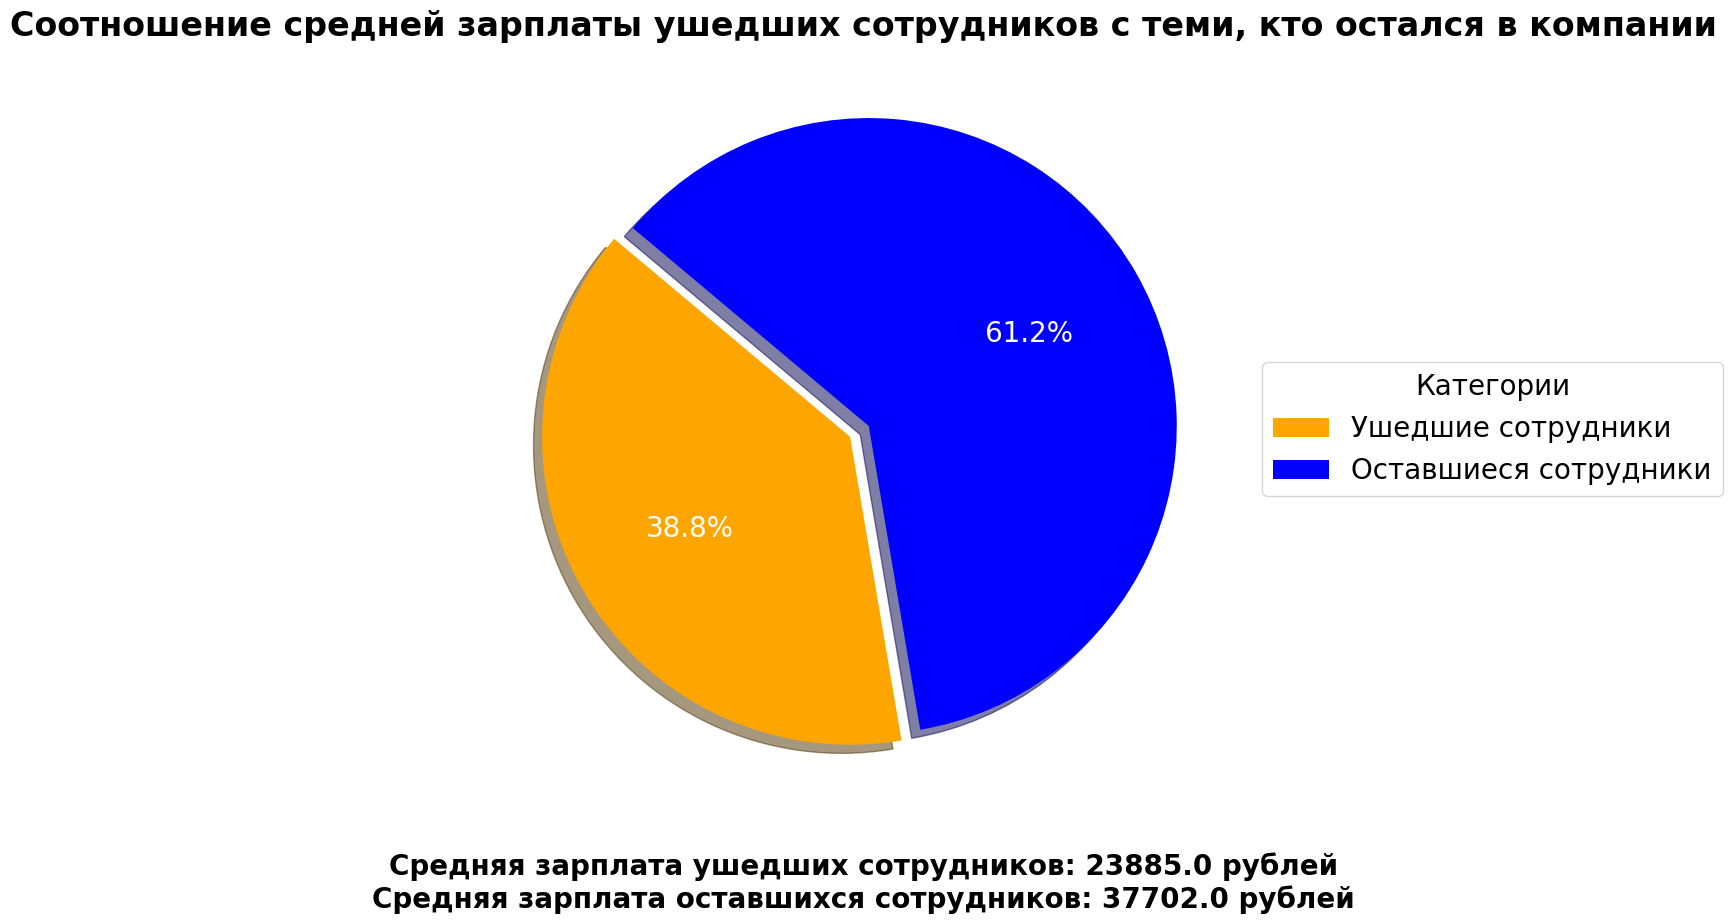

In [465]:
avg_salary_quit = train_quit['salary'][train_quit['quit'] == 'yes'].mean()
avg_salary_stay = train_quit['salary'][train_quit['quit'] == 'no'].mean()

salary_data = [avg_salary_quit, avg_salary_stay]
employee_status = ['Ушедшие сотрудники', 'Оставшиеся сотрудники']

plt.figure(figsize=(10, 10))
plt.rc('font', size=20)

palette = ["orange", "blue"]
explode_values = [0.05, 0.02]
shadow_effect = True
start_angle = 140

wedges, texts, autotexts = plt.pie(salary_data, labels=employee_status, explode=explode_values, colors=palette, autopct='%.1f%%', 
                                   shadow=shadow_effect, startangle=start_angle, textprops={'color': 'w', 'fontsize': 20})

plt.legend(wedges, employee_status, title="Категории", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Соотношение средней зарплаты ушедших сотрудников с теми, кто остался в компании', 
          fontsize=24, fontweight="bold")
plt.xlabel(f'\nСредняя зарплата ушедших сотрудников: {round(avg_salary_quit, 0)} рублей\n'
           f'Средняя зарплата оставшихся сотрудников: {round(avg_salary_stay, 0)} рублей', 
           fontsize=20, fontweight="bold");

График 'Плотность распределения зарплат уволенных и оставшихся сотрудников'

C:\Users\User\AppData\Local\Temp\ipykernel_12640\142568990.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(quit_employees['salary'], label='Уволенные', shade=True)
C:\Users\User\AppData\Local\Temp\ipykernel_12640\142568990.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(not_quit_employees['salary'], label='Оставшиеся', shade=True)


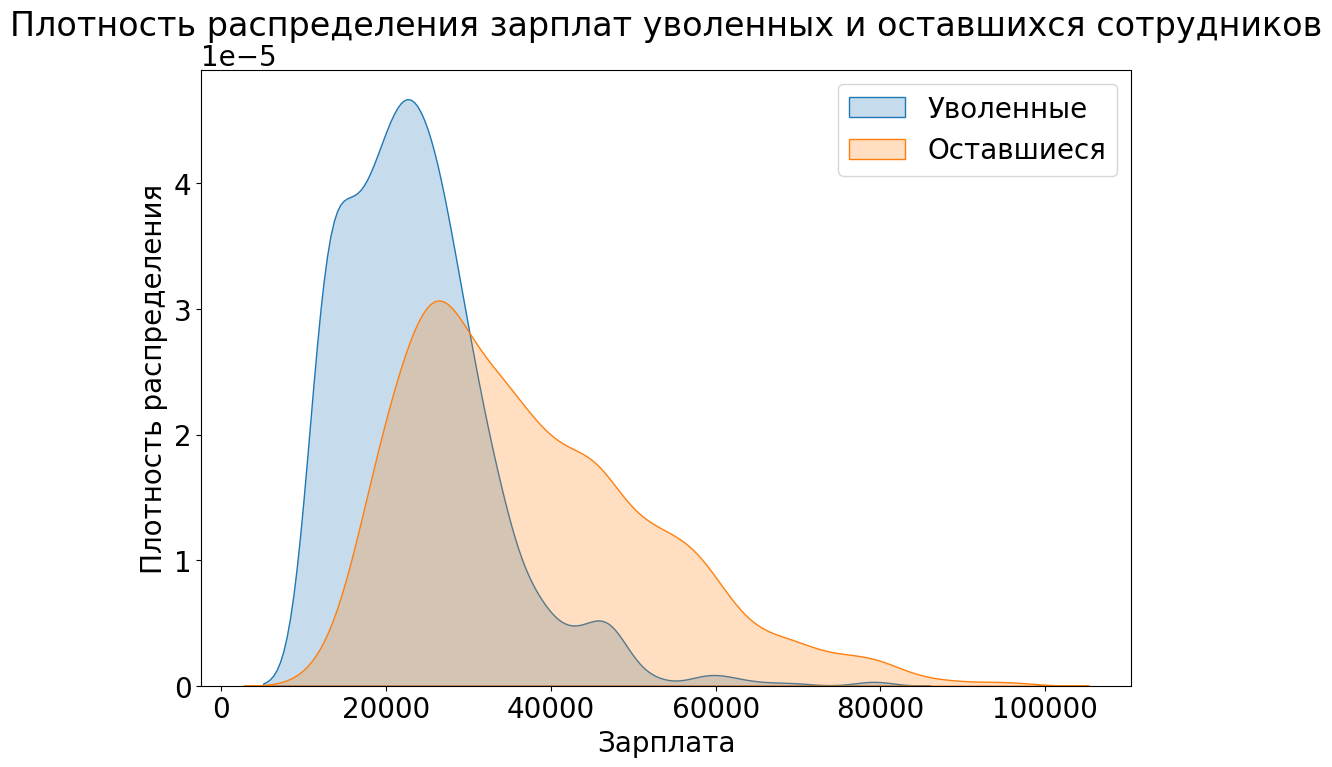

In [466]:
quit_employees = train_quit[train_quit['quit'] == 'yes']
not_quit_employees = train_quit[train_quit['quit'] == 'no']

plt.figure(figsize=(12, 8))

sns.kdeplot(quit_employees['salary'], label='Уволенные', shade=True)
sns.kdeplot(not_quit_employees['salary'], label='Оставшиеся', shade=True)

plt.xlabel('Зарплата')
plt.ylabel('Плотность распределения')
plt.title('Плотность распределения зарплат уволенных и оставшихся сотрудников')

plt.legend();

Гистограмма увольнение от грейда

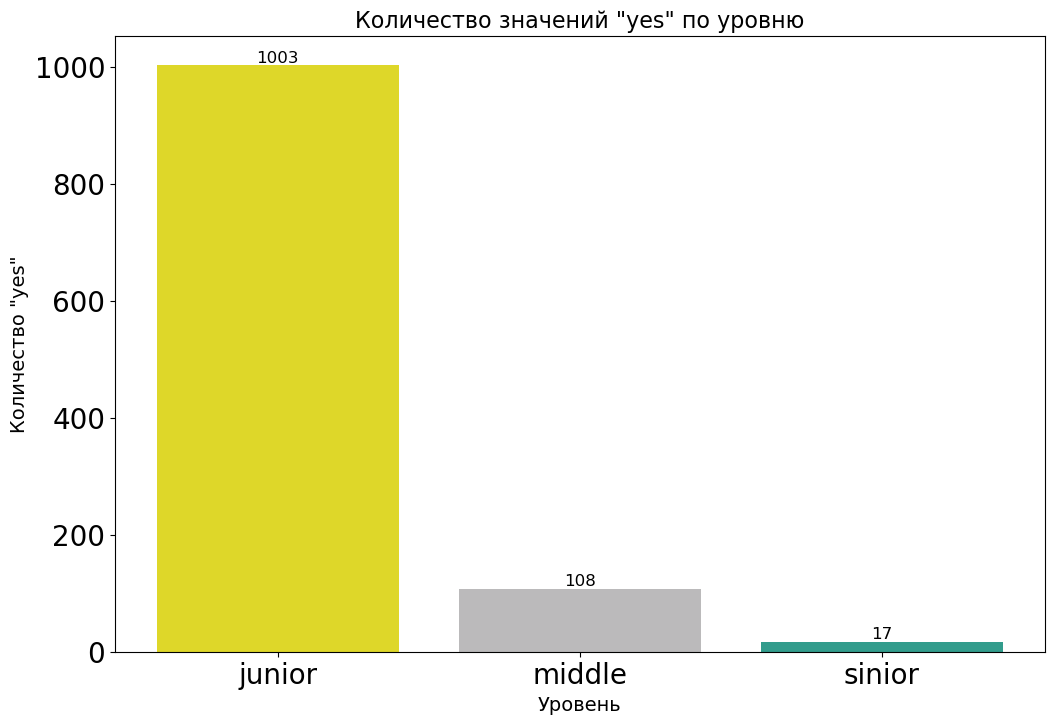

In [467]:
no_counts = train_quit[train_quit['quit'] == 'yes']['level'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(no_counts.index, no_counts.values, color=['#ded729', '#bbbabb', '#329c8c'])

ax.set_xlabel('Уровень', fontsize=14)
ax.set_ylabel('Количество "yes"', fontsize=14)
ax.set_title('Количество значений "yes" по уровню', fontsize=16)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

Гистограмма увольнение от должности

In [468]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


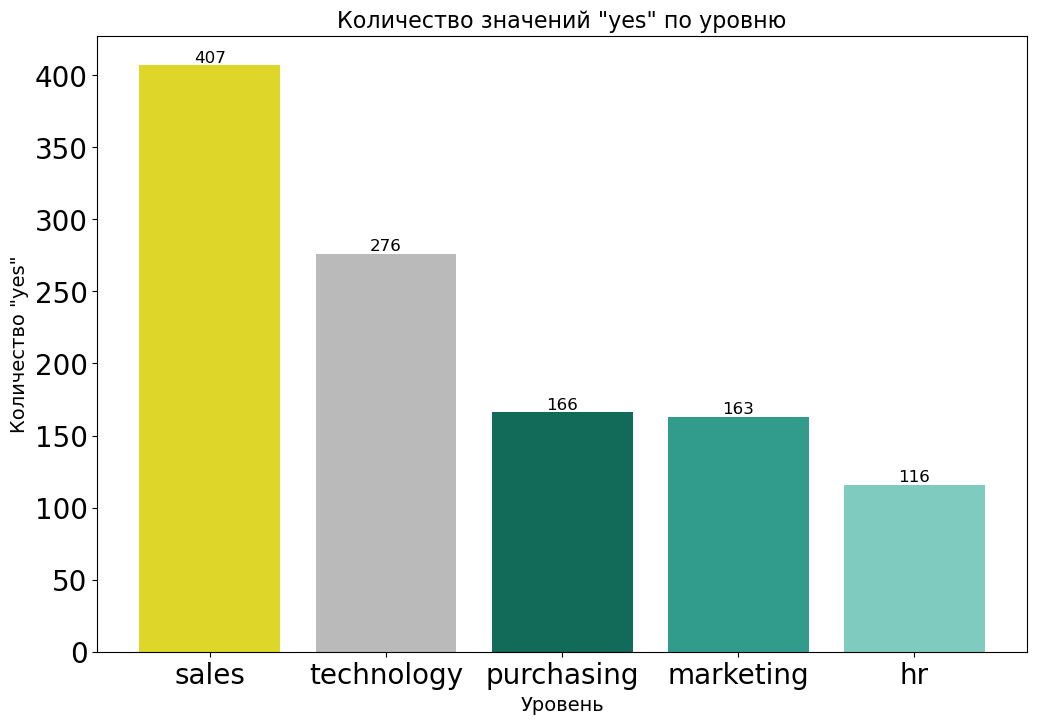

In [469]:
no_counts = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(no_counts.index, no_counts.values, color=['#ded729', '#bbbabb', '#126a58', '#329c8c', '#80cbbf'])

ax.set_xlabel('Уровень', fontsize=14)
ax.set_ylabel('Количество "yes"', fontsize=14)
ax.set_title('Количество значений "yes" по уровню', fontsize=16)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

Гистограмма увольнение от уровня загруженности

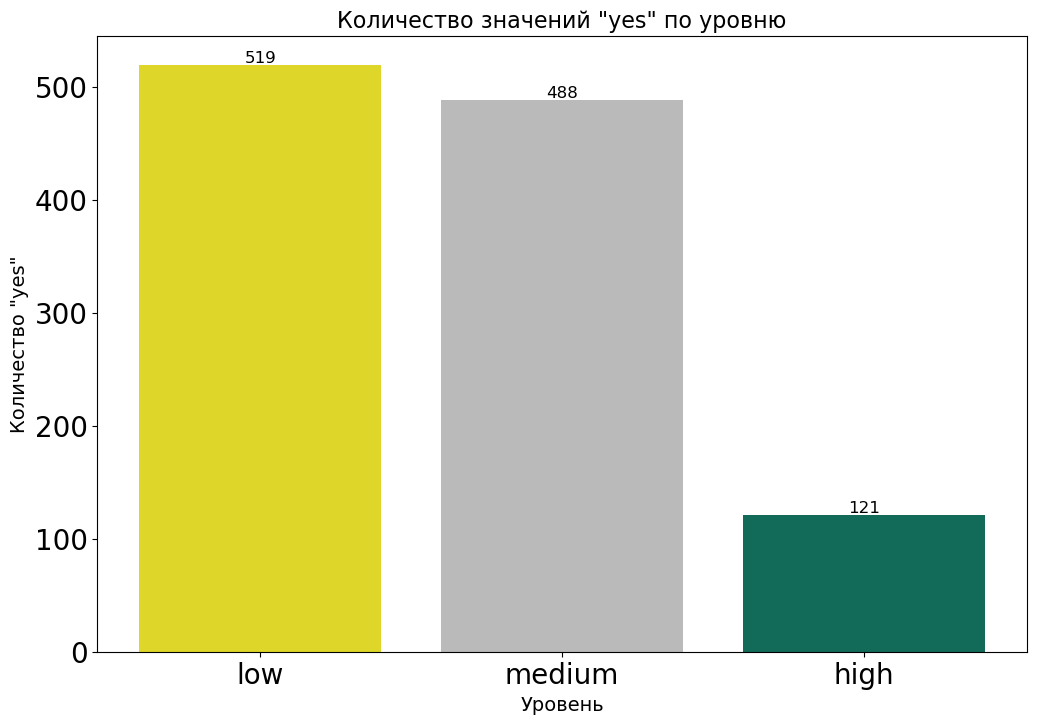

In [470]:
no_counts = train_quit[train_quit['quit'] == 'yes']['workload'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(no_counts.index, no_counts.values, color=['#ded729', '#bbbabb', '#126a58', '#329c8c', '#80cbbf'])

ax.set_xlabel('Уровень', fontsize=14)
ax.set_ylabel('Количество "yes"', fontsize=14)
ax.set_title('Количество значений "yes" по уровню', fontsize=16)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

<b>Вывод:</b>Уволившиеся сотрудники, как правило, имеют младший уровень квалификации (грейд junior) и получают среднюю зарплату в размере 23885. Они чаще всего работают в отделах 'sales' и 'technology', где уровень загруженности работы относительно низкий — маленький и средний. Это может указывать на то, что молодые специалисты в этих отделах не находят достаточных возможностей для профессионального роста или не удовлетворены условиями работы, что приводит к их увольнению.

- Средняя зарплата уволившихся: 23885

- Грейд уволившихся: junior

- Самые популярные отделы: 'sales' и 'technology'

- Загруженность работы: маленькая и средняя


# Добавление нового входного признака

In [471]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [472]:
test_features['job_satisfaction_rate'] = best_model.predict(test_features)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.872000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668621
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824127


# Подготовка данных

Для оптимизации обработки данных, следует применить соответствующие методы кодирования и масштабирования к различным типам признаков:

1. Категориальные признаки с использованием OneHotEncoder:

- dept: Категория отдела.

- last_year_promo: Индикатор прошлогоднего повышения.

- last_year_violations: Уровень нарушений за прошлый год.

Для этих признаков рекомендуется использовать OneHotEncoder, который преобразует категории в набор бинарных признаков, чтобы избежать искусственного упорядочивания.

2. Порядковые признаки с использованием OrdinalEncoder:

- level: Уровень должности.

- workload: Уровень нагрузки.

Примените OrdinalEncoder для этих признаков, чтобы сохранить их порядковую природу, преобразуя категории в числовые значения.

3. Количественные признаки с масштабированием:

- employment_years: Количество лет в компании.

- supervisor_evaluation: Оценка руководителя.

- salary: Размер зарплаты.

- job_satisfaction_rate: Уровень удовлетворенности работой.

Для стандартизации этих количественных признаков используйте метод масштабирования, такой как StandardScaler, который приведет их к единому масштабу, улучшая производительность моделей машинного обучения.

In [473]:
all_target = test_target_quit.merge(test_features, on='id', how='left')
display(all_target.head())

,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.335
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.230
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.670
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.695
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.510


In [474]:
train_quit['quit'] = train_quit['quit'].replace({'yes': 1, 'no': 0}).astype(int)

In [475]:
X_train=train_quit.drop(['id', 'quit'], axis=1)
y_train=train_quit['quit']
X_test=all_target.drop(['quit','id'], axis=1)
y_test=all_target['quit'] 

In [476]:
X_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,technology,junior,medium,1,no,no,3,31200,0.335000
1,sales,middle,medium,10,no,yes,2,32400,0.230000
2,marketing,middle,low,7,no,no,4,20400,0.670000
3,purchasing,middle,low,7,no,no,4,19200,0.695000
4,purchasing,junior,low,1,no,no,4,12000,0.510000
...,...,...,...,...,...,...,...,...,...
1995,sales,junior,high,1,no,no,3,33600,0.610000
1996,purchasing,junior,low,2,no,no,4,12000,0.662778
1997,hr,middle,medium,2,no,no,4,46800,0.645625
1998,sales,middle,medium,1,no,no,5,38400,0.670000


In [477]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [478]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe=Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

param_grid = [

    {
        'models': [RandomForestClassifier()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(10, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]


# Обучение моделей

In [479]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['junior',
                                                                                                                      'middle',
                                                                                                                      's...
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(10, 20),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [486]:
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)
round(grid_search.best_score_,2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                              

0.93

In [487]:
round(roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]),2)

0.93

# Вывод

Лучшая модель для предсказания увольнения сотрудника KNeighborsClassifier показала ROC-AUC 0.93 на тестовой выборке.

# Общий вывод

Для предсказания удовлетворенности и увольнения сотрудников:

Проанализированы данные.

Построена модель с SMAPE ≤ 15% для удовлетворенности (лучшая модель: DecisionTreeRegressor с SMAPE 14.28%).

Для предсказания увольнения построена модель с ROC-AUC ≥ 0.91 (лучшая модель: KNeighborsClassifier с ROC-AUC 0.93).

Установлено RANDOM_STATE = 42 для воспроизводимости.